# Laboratorio: Reti Neurali con scikit-learn

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Proff. Gianluca Moro, Roberto Pasolini  
`nome.cognome@unibo.it`

In [1]:
# setup e test librerie
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [2]:
# funzione per scaricare i file utilizzati
import os
from urllib.request import urlretrieve
def download(file, url):
    if not os.path.isfile(file):
        urlretrieve(url, file)

## Riepilogo: Regressione e limiti dei modelli lineari

- L'obiettivo di un modello di regressione è predire il valore di una variabile $y$ dipendente da altre variabili note $x_1,x_2,\ldots,x_n$
- I modelli lineari prevedono il valore di $y$ come combinazione lineare delle variabili indipendenti
- Tali modelli spesso non sono sufficienti a catturare le relazioni effettive tra le variabili
- Riprendiamo ad esempio il problema della predizione dei consumi elettrici in base alla temperatura
- Carichiamo il dataset in un frame pandas

In [3]:
download("power.csv", "https://git.io/vpaM1")
data = pd.read_csv("power.csv", index_col="date", parse_dates=["date"])

In [4]:
data.head(5)

,demand,temp
date,,
2015-01-01,1.736065,1.7
2015-01-02,1.831672,2.2
2015-01-03,1.714934,14.4
2015-01-04,1.628577,15.6
2015-01-05,2.045394,0.0


- Come visto in precedenza, la relazione tra la temperatura ($x$) e i consumi ($y$) non è lineare

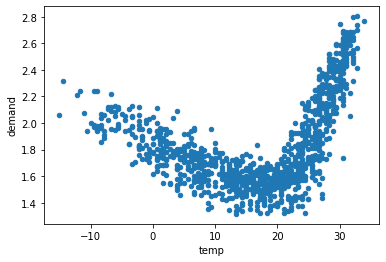

In [5]:
data.plot.scatter("temp", "demand");

- Come in precedenza consideriamo
  - i dati del 2015 e del 2016 come training set
  - quelli del 2017 come validation set
- Per ogni set estraiamo temperature (`X`) e consumi (`y`)

In [6]:
is_train = data.index.year < 2017
X_train = data.loc[is_train, ["temp"]]
y_train = data.loc[is_train, "demand"]
X_val = data.loc[~is_train, ["temp"]]
y_val = data.loc[~is_train, "demand"]

- Eseguiamo la standardizzazione sia delle X che delle y
  - è opportuna per l'utilizzo delle reti neurali
  - non utilizziamo una pipeline per analizzare meglio i passaggi

In [7]:
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_val = X_scaler.transform(X_val)
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values[:, None]).ravel()
y_val = y_scaler.transform(y_val.values[:, None]).ravel()

- Riprendiamo la funzione utilizzata in precedenza per visualizzare le predizioni del modello sovrapposte ai dati
  - sono apportate alcune modifiche per gestire i dati standardizzati

In [8]:
def plot_model_on_data(X_scaled, y_scaled, model=None):
    X = X_scaler.inverse_transform(X_scaled)
    y = y_scaler.inverse_transform(y_scaled[:, None]).ravel()
    plt.scatter(X, y)
    if model is not None:
        xlim, ylim = plt.xlim(), plt.ylim()
        line_x = np.linspace(xlim[0], xlim[1], 100)
        line_x_scaled = X_scaler.transform(line_x[:, None])
        line_y_scaled = model.predict(line_x_scaled)
        line_y = y_scaler.inverse_transform(line_y_scaled[:, None]).ravel()
        plt.plot(line_x, line_y, c="red", lw=3)
        plt.xlim(xlim); plt.ylim(ylim)
    plt.grid()
    plt.xlabel("Temperatura"); plt.ylabel("Consumi")

### Esercizio 1: Regressione lineare

- **(1a)** Addestrare un modello di regressione lineare sul training set
- **(1b)** Calcolare il coefficiente R² del modello sul validation set
- **(1c)** Usare la funzione `plot_model_on_data` per visualizzare il modello sovrapposto al validation set

In [9]:
from sklearn.linear_model import LinearRegression

In [10]:
##solhead:ESERCIZIO 1

In [11]:
##sol:1a
model = LinearRegression()
model.fit(X_train, y_train);

In [12]:
##sol:1b
model.score(X_val, y_val)

0.02795528740713671

/home/rrobby/software/jupyter/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


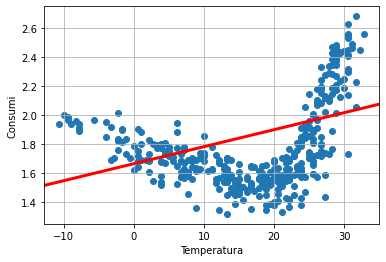

In [13]:
##sol:1c
plot_model_on_data(X_val, y_val, model)

## Multi-layer perceptron

- L'output di un regressore lineare $y$ è determinato dalla combinazione lineare delle variabili $x_1,\ldots,x_n$ in input, ciascuna con un peso diverso
  - quì indichiamo il bias o intercetta come "peso" $w_0$
$$ \hat{y} = w_0+w_1\cdot x_1+\ldots+w_n\cdot x_n $$
- Poniamo di introdurre delle **variabili _nascoste_** (_hidden_) $h_1,\ldots,h_m$ in modo che
  - il valore predetto di y sia combinazione lineare delle variabili nascoste
$$ \hat{y} = w_0+w_1\cdot h_1+\ldots+w_m\cdot h_m $$
  - ciascuna variabile nascosta sia combinazione lineare di quelle in ingresso
$$ h_i = v_{i,0}+v_{i,1}\cdot x_1+\ldots+v_{i,n}\cdot x_n $$
- Questo tipo di modello viene definito _multi-layer perceptron_, in quanto si tratta in pratica di più **modelli lineari disposti a strati**

- Per creare un modello di classificazione di questo tipo usiamo la classe `MLPRegressor`
  - con `hidden_layer_sizes` specifichiamo il numero di variabili nascoste da introdurre, ad esempio 4
  - con `activation="identity"` specifichiamo che tali variabili sono lineari

In [14]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(hidden_layer_sizes=4, activation="identity")

- Eseguiamo ora l'addestramento del modello
  - viene utilizzata la discesa gradiente _stocastica_: ciascun aggiustamento dei pesi è basato su un campione casuale di osservazioni di training
  - l'errore e la relativa derivata sono calcolati per l'output finale e a cascata per ciascuna delle variabili nascoste (_backpropagation_)

In [15]:
model.fit(X_train, y_train);

- Negli attributi `coefs_` e `intercepts_` del modello addestrato troviamo liste di array con pesi e bias suddivisi per strato
  - allo strato 0 troviamo 1×4 pesi e 4 bias con cui dalla variabile di input sono calcolate le 4 nascoste
  - allo strato 1 troviamo 4 pesi e 1 bias con cui dalle 4 variabili intermedie è calcolato l'output finale

![schema MLP](https://kroki.io/graphviz/png/eNqVkE1LxDAURff9FZeuRqhg6-wkbgdBEFy4EZG0eU4ehqTkA1tL_7vpjIoDdTGbB8m7uecQxXsve40dpgJe2nfFXtw_Fgi9YUtBLBMFrFOE5zceSAX-JBF9ogpGtmREWb7c5AepPVZ1JoVI_vVqqUTnjPPiQ3OkHPruCXE0JIIzrKpjoDWJthWClj2Jjn1naCnFUC_zwIFAeWf7FLEZLsp8Pa9A63OgnlSzwtQ1dAN9Db09gT9Jz7Jlw7AydC7zsNH_mjTnmASSe09k13TGXwlRPqR4-IDxBzsN9YzLW0x_pOe8OjkvgdwyF1_wDp7M)

In [16]:
model.coefs_

[array([[-0.33258258,  0.46283137, -0.99621293, -0.36454643]]),
 array([[ 0.83448391],
        [ 0.20002628],
        [-0.80855291],
        [ 0.69408187]])]

In [17]:
model.intercepts_

[array([-0.64826771,  0.13872196, -0.03415964, -0.07303244]),
 array([0.53547756])]

- Vediamo come prima il grafico del modello sovrapposto ai dati

/home/rrobby/software/jupyter/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


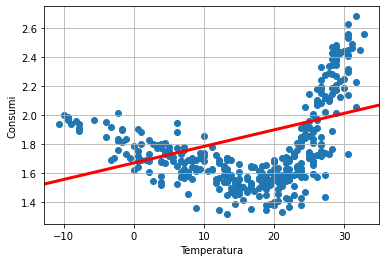

In [18]:
##noerr
plot_model_on_data(X_val, y_val, model)

- Il grafico risulta simile a quello di un modello lineare semplice
- Anche il coefficiente R² rimane scarso

In [19]:
model.score(X_val, y_val)

0.02970392880213424

- Questo perché, anche con più strati, l'output finale **rimane una combinazione lineare dell'input**
$$ y = (\ldots) + (\ldots)\cdot x_1 + (\ldots)\cdot x_2 + \ldots + (\ldots)\cdot x_n $$
- Possiamo aggiungere espressività al modello introducendo **trasformazioni non lineari**

## Funzione di attivazione ReLU

- La funzione _ReLU_ (_rectified linear unit_) è un esempio di funzione che introduce non linearità
$$ \text{ReLU}(x) = \max(0, x) $$
- Definiamola in Python, usando la funzione `maximum` di NumPy per ottenerne una versione vettoriale (applicabile ad un array di valori)

In [20]:
def relu(x):
    return np.maximum(0, x)

- Possiamo usarla ad es. per tracciarne il grafico

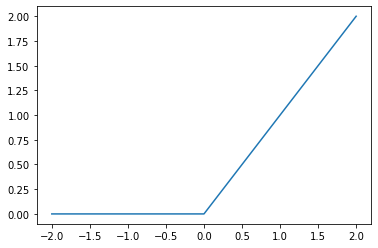

In [21]:
px = np.linspace(-2, 2, 101)
py = relu(px)
plt.plot(px, py);

- Essendo una funzione **continua e derivabile**, rimane utilizzabile nel modello addestrato con la discesa gradiente (stocastica)

- Riconfiguriamo il modello in modo tale che il valore delle variabili nascoste sia il risultato dell'applicazione di ReLU alla combinazione lineare degli input
$$ h_i = \text{ReLU}(v_{i,0}+v_{i,1}\cdot x_1+\ldots+v_{i,n}\cdot x_n) $$
- Per far ciò, specifichiamo `activation="relu"` (default) nella configurazione di `MLPRegressor`
- Addestriamo un modello con 2 sole variabili nascoste per poterle visualizzare in seguito

In [22]:
model = MLPRegressor(hidden_layer_sizes=8, activation="relu", random_state=42)

- Addestriamo il modello sui dati di training e valutiamo l'accuratezza su quelli di validation

In [23]:
%time model.fit(X_train, y_train);

CPU times: user 197 ms, sys: 736 µs, total: 198 ms
Wall time: 197 ms


/home/rrobby/software/jupyter/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=8, random_state=42)

In [24]:
model.score(X_val, y_val)

0.5832615372865531

- Vediamo che l'accuratezza è migliorata

/home/rrobby/software/jupyter/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


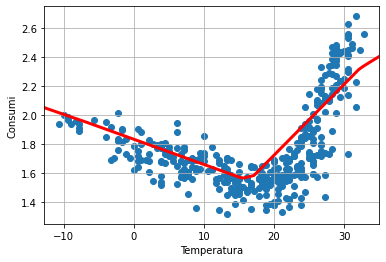

In [25]:
plot_model_on_data(X_val, y_val, model)

- Tramite un numero N di variabili nascoste ReLU, l'algoritmo ha individuato un modello rappresentabile con una linea che può essere "spezzata" in un massimo di N punti

## Iperparametri per l'addestramento

### Numero di epoche

- Il multi-layer perceptron ha molti iperparametri impostabili oltre a quelli visti
- Tra questi possiamo impostare il numero massimo di _epoche_, ovvero di iterazioni compiute sul training set
  - ad ogni iterazione, la discesa gradiente stocastica processa le osservazioni in gruppi casuali, detti _minibatch_
- Possiamo impostare il numero di epoche col parametro `max_iter`
- Di default è 200, proviamo quì ad alzarlo a 2.000 mantenendo le stesse impostazioni di prima

In [26]:
model = MLPRegressor(hidden_layer_sizes=8, max_iter=2000, activation="relu", random_state=42)
%time model.fit(X_train, y_train);

CPU times: user 396 ms, sys: 638 µs, total: 396 ms
Wall time: 396 ms


MLPRegressor(hidden_layer_sizes=8, max_iter=2000, random_state=42)

- Il tempo per addestrare il modello aumenta, ma anche l'accuratezza

In [27]:
model.score(X_val, y_val)

0.7028922828467308

/home/rrobby/software/jupyter/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


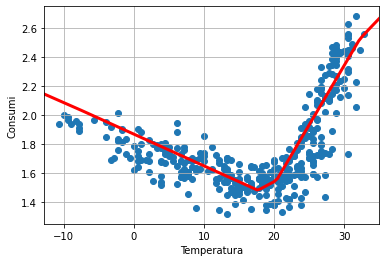

In [28]:
plot_model_on_data(X_val, y_val, model)

### Batch size

- Possiamo anche variare la _batch size_, ovvero il numero di osservazioni in ogni minibatch durante l'addestramento
- Proviamo ad esempio a mantenere le 200 epoche di default, ma a cambiare la batch size da 200 (default) a 20

In [29]:
model = MLPRegressor(hidden_layer_sizes=8, batch_size=20, activation="relu", random_state=42)
%time model.fit(X_train, y_train);

CPU times: user 1.1 s, sys: 6.42 ms, total: 1.11 s
Wall time: 1.1 s


MLPRegressor(batch_size=20, hidden_layer_sizes=8, random_state=42)

- Anche in questo caso il tempo per l'addestramento è aumentato rispetto a prima, in quanto ciascuna epoca richiede più passaggi, ma anche in questo modo l'accuratezza è migliorata

In [30]:
model.score(X_val, y_val)

0.7175758523640118

/home/rrobby/software/jupyter/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


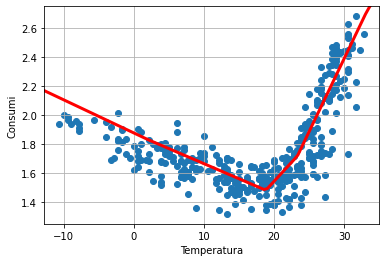

In [31]:
plot_model_on_data(X_val, y_val, model)

## Classificazione non lineare

- In un problema di _classificazione_ dobbiamo suddividere correttamente delle osservazioni in _classi_ predefinite
  - a differenza della regressione in cui dobbiamo predire un valore in un dominio continuo
- I casi più comuni prevedono la classificazione _binaria_, ovvero con due possibili classi
- I modelli lineari funzionano tramite l'individuazione di un _iperpiano_ nello spazio delle variabili che separi quanto meglio possibile le osservazioni tra le due classi
- Possiamo avere a che fare però con set di dati con classi non linearmente separabili, per cui tali classificatori non possono funzionare in modo soddisfacente
- Vediamo un esempio di funzionamento con un dataset sintetico generato casualmente
- La funzione `make_circles` genera punti in un piano distribuiti in due corone circolari concentriche

- Generiamo due dataset casuali con distribuzione simile ma seed diversi, uno per training e l'altro per validazione

In [32]:
from sklearn.datasets import make_circles
X_train, y_train = make_circles(1000, noise=0.1, factor=0.5, random_state=23)
X_val,   y_val   = make_circles(1000, noise=0.1, factor=0.5, random_state=42)

- Ciascuna istanza è un punto sul piano, la cui classe è 0 (cerchio esterno) o 1 (cerchio interno)

In [33]:
X_train[:5]

array([[ 0.4677266 ,  0.05443974],
       [-0.34703554, -0.30774354],
       [-0.915094  ,  0.46046701],
       [ 0.48564263,  0.22661689],
       [ 0.6280253 , -0.08921573]])

In [34]:
y_train[:5]

array([1, 1, 0, 1, 1])

- Visualizziamo i punti del training set, colorati in base alla loro classe reale

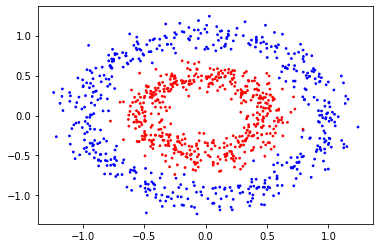

In [35]:
# X_train.T -> matrice con 2 righe, rispettivamente con le coordinate x e y
# l'asterisco scompone le due righe della matrice nei due argomenti da passare a "scatter"
plt.scatter(*X_train.T, s=3, c=np.where(y_train, "red", "blue"));

- Vogliamo addestrare un classificatore a distinguere, date le coordinate di un punto, se faccia parte del cerchio esterno o di quello interno

### Esercizio 2: Modello di classificazione lineare

- **(2a)** Addestrare un modello di regressione logistica sui dati di training
- **(2b)** Calcolare l'accuratezza del modello sul validation set
- **(2c)** Creare un grafico a dispersione del validation set con i punti colorati in base alla classe predetta dal modello

In [36]:
from sklearn.linear_model import LogisticRegression

In [37]:
##solhead:ESERCIZIO 2

In [38]:
##sol:2a
model = LogisticRegression(solver="saga")
model.fit(X_train, y_train);

In [39]:
##sol:2b
model.score(X_val, y_val)

0.497

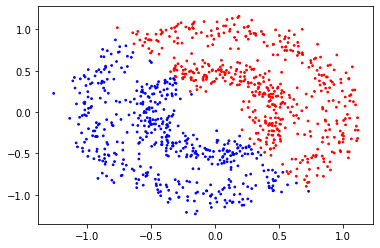

In [40]:
##sol:2c
y_pred = model.predict(X_val)
plt.scatter(*X_val.T, s=3, c=np.where(y_pred, "red", "blue"));

- Essendo un classificatore lineare, non è in grado di separare correttamente le due classi
- Per maggiore dettaglio, creiamo una funzione per visualizzare le regioni di spazio in cui il classificatore suddivide i dati

In [41]:
def plot_class_model(X, y, model):
    plt.scatter(X[:, 0], X[:, 1])
    xlim, ylim = plt.xlim(), plt.ylim()
    mx = np.linspace(xlim[0], xlim[1], 101)
    my = np.linspace(ylim[0], ylim[1], 101)
    mx, my = np.meshgrid(mx, my)
    try:
        # se son disponibili le probabilità, crea uno sfondo sfumato in base ad esse
        mz = model.predict_proba(np.c_[mx.ravel(), my.ravel()])[:, 1].reshape(mx.shape)
    except AttributeError:
        # altrimenti mostra la separazione netta tra le due classi
        mz = model.predict(np.c_[mx.ravel(), my.ravel()]).reshape(mx.shape)
    plt.contourf(mx, my, mz, cmap="cool")
    plt.scatter(X[:, 0], X[:, 1], c=np.where(y, "#880000", "blue"), s=4)

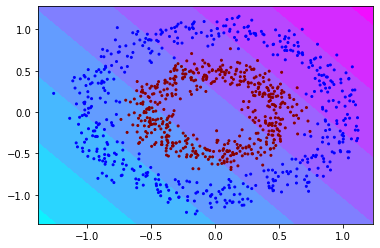

In [42]:
plot_class_model(X_val, y_val, model)

- Le sfumature sullo sfondo indicano le probabilità con cui il classificatore assegna un punto ad una classe o all'altra

- Conoscendo la forma del dataset, possiamo introdurre nuove variabili specifiche tali per cui le classi diventino linearmente separabili
- Introduciamo ad esempio variabili polinomiali di secondo grado

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
model = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("lr",   LogisticRegression(solver="saga"))
])
model.fit(X_train, y_train);

In [44]:
model.score(X_val, y_val)

0.993

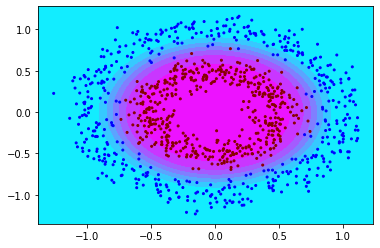

In [45]:
plot_class_model(X_val, y_val, model)

- Grazie all'uso dei quadrati delle variabili come feature, è possibile separare linearmente le due classi

- A conferma, si vedano i coefficienti del modello di regressione: i due con valori più significativi sono quelli dei quadrati (`x0^2` e `x1^2`)

In [46]:
##noerr
pd.Series(
    model.named_steps["lr"].coef_[0],
    index=model.named_steps["poly"].get_feature_names()
)

/home/rrobby/software/jupyter/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


x0       0.007849
x1      -0.075367
x0^2    -8.344511
x0 x1   -0.053146
x1^2    -8.368226
dtype: float64

- Si veda inoltre il grafico a dispersione dove invece delle variabili `x0` e `x1` rappresentiamo i rispettivi quadrati

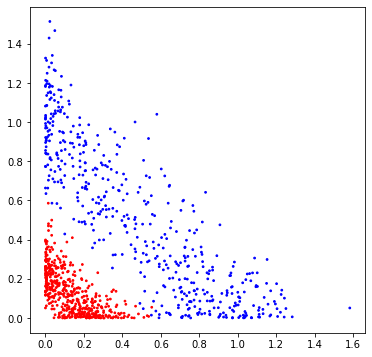

In [47]:
plt.figure(figsize=(6, 6))
plt.scatter(*(X_val**2).T, s=3, c=np.where(y_val, "red", "blue"));

- Con questa rappresentazione le due classi sono linearmente separabili
- Tale rappresentazione è però stata decisa arbitrariamente da noi
- Come ottenere un modello accurato senza generare manualmente delle feature?

## Multi-layer Perceptron per la classificazione

- In modo analogo a quanto visto sopra per la regressione, possiamo definire l'iperpiano di separazione in funzione di un numero di variabili nascoste $h_1,\ldots,h_m$ ...
$$ w_0+w_1\cdot h_1+\ldots+w_m\cdot h_m = 0 $$
- ...e definire tali variabili nascoste in funzione degli input $x_1,x_2,\ldots,x_n$
$$ h_i = v_{i,0}+v_{i,1}\cdot x_1+\ldots+v_{i,n}\cdot x_n $$
- Per creare un modello di classificazione di questo tipo usiamo la classe `MLPClassifier`, che accetta molti degli stessi parametri di `MLPRegressor`
  - con `hidden_layer_sizes` specifichiamo il numero di variabili nascoste da introdurre, ad esempio 4
  - con `activation="identity"` specifichiamo che tali variabili sono lineari

In [48]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=4, activation="identity")

- Eseguiamo ora l'addestramento del modello, come sopra usando la discesa gradiente stocastica

In [49]:
model.fit(X_train, y_train);

- Negli attributi `coefs_` e `intercepts_` del modello addestrato troviamo le liste di array con pesi e bias suddivisi per strato
  - allo strato 0 troviamo 2×4 pesi e 4 bias con cui dalle 2 variabili di input sono calcolate le 4 nascoste
  - allo strato 1 troviamo 4 pesi e 1 bias con cui dalle 4 variabili intermedie è calcolato l'output finale

![schema MLP](https://kroki.io/graphviz/png/eNqVkEtLxDAUhff9FYeuRqhg6-wkbgdBGJiFGxFJm-vkYkhLHtha-t9NOyoO1MVsQh4n33e4io9Odho7jBmctO-KnXg8ZPCdYUtezCsy2FYRnt-4J-X5k0RwkQoYWZMRef5ylz7E-oRqTPSB3OvNjETTmtaJD82BUuib48NgSPjWsCpOgdpE2hbwWnYkGnaNoRmKvkRfzZtFBYH8wXYxYNNf5el6WvGWl3gdqWpFq0voCvoWensmf5KOZc2GYaVv2uTDRv_bpLqkiSd5dER2rc7wW0Lk-xiWAQw_2nGZ0YTre4x_ek_p9ew8BxJoyr4AfqGgYA==)

In [50]:
model.coefs_

[array([[ 0.44454921,  0.14667562, -0.76974697, -0.48852129],
        [ 0.07152733, -0.73240054, -1.13476271, -0.67592606]]),
 array([[ 0.39290564],
        [-0.43175893],
        [ 0.53734628],
        [-0.61989142]])]

In [51]:
model.intercepts_

[array([-0.84457148, -0.21161832, -0.02058965, -0.0228384 ]),
 array([0.23647131])]

- Vediamo come prima il grafico con le probabilità delle classi indicate dal modello e la sua accuratezza

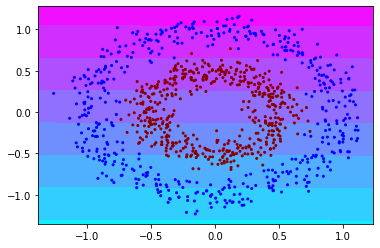

In [52]:
plot_class_model(X_val, y_val, model)

In [53]:
model.score(X_val, y_val)

0.499

- Anche in questo caso, usando strati lineari il modello finale rimane lineare
- Come sopra, usiamo la funzione ReLU per introdurre non-linearità
  - specifichiamo `activation="relu"` (default) nella configurazione di `MLPClassifier`
- Addestriamo un modello con 2 sole variabili nascoste per poter visualizzarle in seguito

In [54]:
model = MLPClassifier(hidden_layer_sizes=2, activation="relu", random_state=23757)

- Addestriamo il modello sui dati di training e valutiamo l'accuratezza su quelli di validation

In [55]:
model.fit(X_train, y_train);

/home/rrobby/software/jupyter/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [56]:
model.score(X_val, y_val)

0.698

- Vediamo che l'accuratezza è migliorata

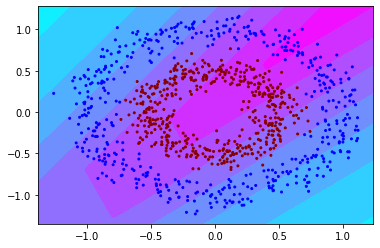

In [57]:
plot_class_model(X_val, y_val, model)

- Tramite le variabili nascoste non lineari, il modello è riuscito a individuare una suddivisione delle classi composta da più iperpiani

- Possiamo visualizzare i dati nello spazio delle due variabili nascoste
- Dal validation set `X_val` ricaviamo i corrispondenti valori `H_val` delle variabili nascoste
  - usiamo pesi e bias del primo strato del modello per calcolare la combinazione lineare degli input, quindi applichiamo la funzione ReLU

In [58]:
H_val = relu(X_val @ model.coefs_[0] + model.intercepts_[0])

- Visualizziamo quindi un grafico a dispersione su queste due variabili, colorando i dati in base alla classe effettiva

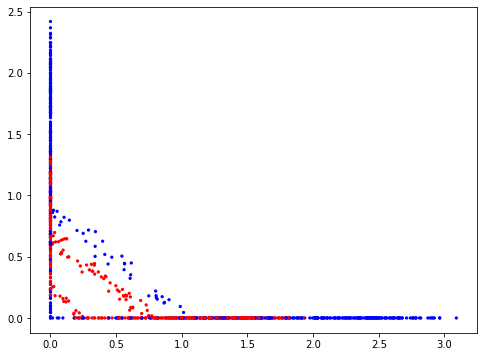

In [59]:
plt.figure(figsize=(8, 6))
plt.scatter(*H_val.T, s=5, c=np.where(y_val, "red", "blue"));

- Si nota che in questo spazio si può ottenere una separazione lineare migliore (anche se non netta) delle due classi
- Possiamo sovrapporre al grafico l'iperpiano individuato dallo strato di output

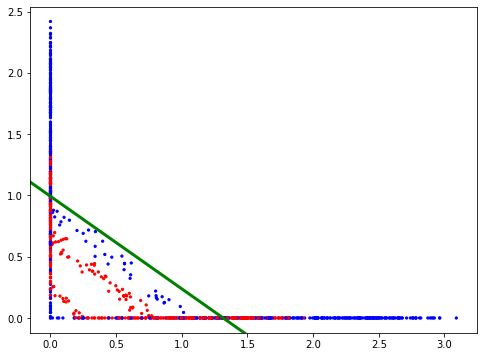

In [60]:
# ricreo lo scatter plot sopra
plt.figure(figsize=(8, 6))
plt.scatter(*H_val.T, s=5, c=np.where(y_val, "red", "blue"))
xlim, ylim = plt.xlim(), plt.ylim()
# ricavo pesi e bias dell'ultimo strato della rete
w = model.coefs_[1].T[0]
b = model.intercepts_[1]
# estraggo campioni di punti dell'iperpiano e lo disegno
sep_x = np.linspace(*xlim, 2)
sep_y = -w[0]/w[1]*sep_x -b/w[1]
plt.plot(sep_x, sep_y, c="green", lw=3);
plt.xlim(xlim); plt.ylim(ylim);

- Aumentiamo ora il numero di variabili nascoste a 6, per aumentare l'espressività del modello

In [61]:
model = MLPClassifier(hidden_layer_sizes=6, activation="relu", random_state=42)
%time model.fit(X_train, y_train);

CPU times: user 300 ms, sys: 124 µs, total: 300 ms
Wall time: 300 ms


/home/rrobby/software/jupyter/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=6, random_state=42)

In [62]:
model.score(X_val, y_val)

0.946

- L'accuratezza è nettamente migliorata

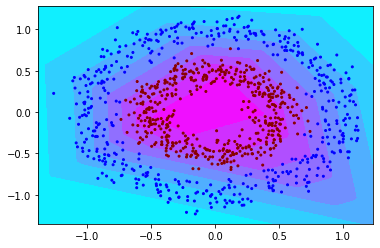

In [63]:
plot_class_model(X_val, y_val, model)

- Dalla combinazione lineare di un numero sufficiente di variabili nascoste, riusciamo ad ottenere un'ottima approssimazione del modello basato su variabili di grado 2 **senza aver definito manualmente alcuna variabile!**

- Come per `MLPRegressor`, possiamo impostare differentemente il numero massimo di epoche di training `max_iter` e il numero di istanze `batch_size` per ogni passo di addestramento
- Addestriamo un modello aumentando `max_iter` da 200 (default) a 1.000...

In [64]:
model = MLPClassifier(hidden_layer_sizes=6, max_iter=1000, activation="relu", random_state=42)
%time model.fit(X_train, y_train);

CPU times: user 1.51 s, sys: 291 µs, total: 1.51 s
Wall time: 1.51 s


MLPClassifier(hidden_layer_sizes=6, max_iter=1000, random_state=42)

In [65]:
model.score(X_val, y_val)

0.989

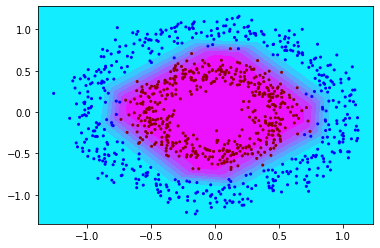

In [66]:
plot_class_model(X_val, y_val, model)

- ...e uno diminuendo `batch_size` da 200 (default) a 50

In [67]:
model = MLPClassifier(hidden_layer_sizes=6, batch_size=50, activation="relu", random_state=42)
%time model.fit(X_train, y_train);

CPU times: user 1 s, sys: 213 µs, total: 1 s
Wall time: 1 s


/home/rrobby/software/jupyter/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(batch_size=50, hidden_layer_sizes=6, random_state=42)

In [68]:
model.score(X_val, y_val)

0.992

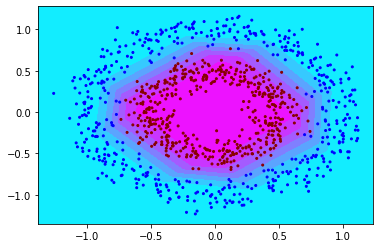

In [69]:
plot_class_model(X_val, y_val, model)

- In entrambi i casi, il tempo per l'addestramento aumenta ma l'accuratezza migliora sensibilmente
- Si può notare che il modello è più preciso e anche più "sicuro": la distribuzione delle probabilità varia in modo più netto da un cerchio all'altro

## Learning rate

- Un altro parametro variabile è il _learning rate_, la velocità con cui i pesi variano nella discesa gradiente
- Si imposta col parametro `learning_rate_init`
  - questo è il learning rate iniziale, l'algoritmo di addestramento può ridurlo progressivamente
- Testiamo ad esempio ad aumentare il learning rate da 0,001 (default) a 0,01

In [70]:
model = MLPClassifier(hidden_layer_sizes=6, learning_rate_init=0.01, activation="relu", random_state=42)
%time model.fit(X_train, y_train);

CPU times: user 295 ms, sys: 547 µs, total: 295 ms
Wall time: 294 ms


/home/rrobby/software/jupyter/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=6, learning_rate_init=0.01, random_state=42)

In [71]:
model.score(X_val, y_val)

0.989

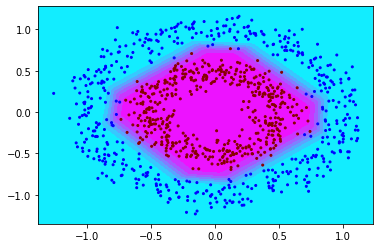

In [72]:
plot_class_model(X_val, y_val, model)

- Siamo riusciti in questo caso ad ottenere un'ottima accuratezza senza aumentare i tempi di addestramento
- In problemi più complessi però un aumento del learning rate può portare ad un modello "instabile"

## Modelli con più strati nascosti

- Nei modelli sopra abbiamo considerato un unico strato di variabili nascoste
- Possiamo però introdurre un numero arbitrario di questi strati, in modo tale che l'input di ciascuno sia l'output di quello sottostante
- Ciascuno strato può avere un numero diverso di variabili nascoste
  - generalmente il numero di variabili si riduce man mano che ci si avvicina all'output finale della rete
  - l'idea è che le variabili negli **strati superiori** (più vicini all'output della rete) rappresentino **informazioni di più alto livello** rispetto a quelli sottostanti

- Consideriamo ad esempio un modello dove
  - un primo strato di 4 variabili nascoste è calcolato dalle variabili in input
  - da queste viene calcolato un secondo strato di 2 variabili nascoste
  - da queste viene calcolato l'output finale

![schema MLP](https://kroki.io/graphviz/png/eNqtkU9LxDAQxe_9FI-eFCrY7t4kXkUQBA9eRCRtxk3WkJb8wdbS726aqrhQDyt7CZOZyfu9mQi1s7yTuMGYwXLzJpRldw8ZXKeVIcfmExlMKwhPr6on4dQHMW8DFdC8Js3y_PkqPgj1ItXo4DzZl8tZEk2rW8vepfIUm750nB80MddqJYqlodaBtgWc5B2xRtlG0yyKvkRfzUFCgSG_NV3wOOvP85ieVrjlMVxLolrByhKygtxAbg_gj9wqXiutYLhr2sj7y0V1Ahf7Evvqn_zNMXxHfGeJzJqJ4ccAy--DT8sfvpc_pv-ZcHGN8dfOplg9uKeGNE4qLdGcjOpT9glz1891)

- Creiamo un `MLPClassifier` indicando in `hidden_layer_sizes` una tupla con i numeri di variabili in ciascuno strato, in questo caso 4 e 2

In [73]:
model = MLPClassifier(hidden_layer_sizes=(4, 2), activation="relu", random_state=346346)
model.fit(X_train, y_train);

/home/rrobby/software/jupyter/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [74]:
model.score(X_val, y_val)

0.903

- Questa volta abbiamo tre gruppi di pesi e bias: quelli del primo strato nascosto, quelli del secondo e quelli per l'output

In [75]:
model.coefs_

[array([[-0.39325268, -1.97450343,  0.29704215,  1.0615451 ],
        [-1.35165159, -1.10714854, -1.08765132, -1.37464659]]),
 array([[ 0.68017556,  0.30916924],
        [-1.12797845,  0.19131857],
        [ 1.04889929,  0.03509317],
        [-2.09441281,  1.48976843]]),
 array([[ 1.31517725],
        [-0.97719811]])]

In [76]:
model.intercepts_

[array([ 1.2544295 , -0.11637562,  1.11916832, -0.33474098]),
 array([ 0.27230613, -0.42928501]),
 array([-0.96960548])]

- Con l'aggiunta di molteplici strati si possono creare suddivisioni più complesse dello spazio

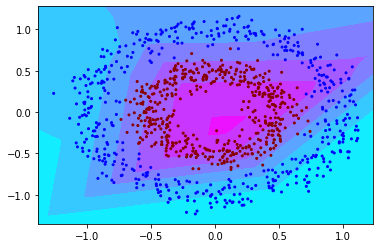

In [77]:
plot_class_model(X_val, y_val, model)

### Esercizio 3: Visualizzazione delle variabili nascoste

- Visualizzare in un grafico a dispersione la distribuzione dei dati del validation set nello spazio individuato dal secondo strato nascosto del modello, sovrapponendo l'iperpiano di separazione individuato dallo strato di output
  - adattare il codice utilizzato sopra per calcolare e visualizzare le variabili nascoste nella rete con un singolo strato nascosto

In [78]:
##solhead:ESERCIZIO 3

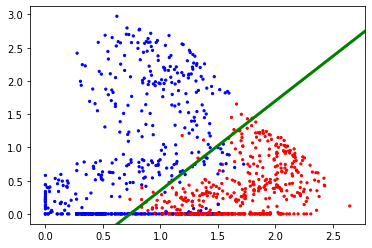

In [79]:
##sol
# dalle variabili di input calcoliamo quelle del primo strato nascosto
H1_val = relu(X_val @ model.coefs_[0] + model.intercepts_[0])

# da queste calcoliamo quelle del secondo strato nascosto
H2_val = relu(H1_val @ model.coefs_[1] + model.intercepts_[1])

# generiamo il grafico, adattando il codice usato sopra
plt.scatter(*H2_val.T, s=5, c=np.where(y_val, "red", "blue"))
xlim, ylim = plt.xlim(), plt.ylim()
w = model.coefs_[2].T[0]
b = model.intercepts_[2]
sep_x = np.linspace(*xlim, 2)
sep_y = -w[0]/w[1]*sep_x -b/w[1]
plt.plot(sep_x, sep_y, c="green", lw=3);
plt.xlim(xlim); plt.ylim(ylim);

- Il _multi-layer perceptron_ visto quì è un esempio semplice di _rete neurale_, un modello di apprendimento basato sulla combinazione di molteplici nodi
  - ciascun nodo è un semplice modello lineare con applicata una _funzione di attivazione_, es. ReLU
- I modelli per le applicazioni reali più complesse possono arrivare ad avere molti strati (es. una decina) con un numero enorme di nodi complessivi (es. milioni)
- Questi modelli sono alla base del _deep learning_, l'apprendimento basato su **molteplici livelli di astrazione** dei dati **appresi automaticamente** dal modello stesso
  - sono modelli particolarmente appropriati per il processamento di dati **non strutturati**, quali immagini e testi, da cui solitamente è necessario estrarre manualmente molte feature

## Esercizio 4: Modello multi-layer perceptron su caso di studio

- Riprendiamo il dataset del caso di studio sulla classificazione delle cellule tumorali

In [80]:
# scarico il dataset se necessario
download(
    "wbdc.data",
    "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
)

In [81]:
# carico il dataset con pandas e imposto i nomi delle colonne
bcwds = pd.read_csv("wbdc.data", header=None, index_col=0)
cell_features = ["radius",     "texture",
                 "perimeter",  "area",
                 "smoothness", "compactness",
                 "concavity",  "concave_pts",
                 "symmetry",   "fractal_dim"]
stats = ["mean", "std", "worst"]
bcwds.columns = ["diagnosis"] + [f"{stat}_{feat}" for stat in stats for feat in cell_features]

In [82]:
# suddivido tra training e validation set
from sklearn.model_selection import train_test_split
X = bcwds.drop(columns="diagnosis")
y = bcwds["diagnosis"]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=1/3, random_state=42)

- **(4a)** Effettuare una grid search con cross validation a 3 fold stratificati sul training set per individuare i parametri migliori di un classificatore multi-layer perceptron con
  - standardizzazione dei dati in ingresso
  - 3 possibili configurazione degli strati nascosti
    - uno strato di 16 variabili
    - uno strato di 32 variabili
    - due strati di 16 e 8 variabili rispettivamente
  - batch size di 100 oppure 200
- **(4b)** Ottenere la configurazione risultata migliore
- **(4c)** Verificare sul test set l'accuratezza del modello con tale configurazione

In [83]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [84]:
##solhead:ESERCIZIO 4

In [85]:
##sol:4a
model = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(activation="relu"))
])
grid = {
    "mlp__hidden_layer_sizes": [16, 32, (16, 8)],
    "mlp__batch_size": [100, 200]
}
skf = StratifiedKFold(3, shuffle=True)
gs = GridSearchCV(model, grid, cv=skf)
gs.fit(X_train, y_train);

/home/rrobby/software/jupyter/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/rrobby/software/jupyter/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/rrobby/software/jupyter/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/rrobby/software/jupyter/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/rrobby

In [86]:
##sol:4b
gs.best_params_

{'mlp__batch_size': 100, 'mlp__hidden_layer_sizes': (16, 8)}

In [87]:
##sol:4c
gs.score(X_test, y_test)

0.9631578947368421